In [15]:
# 先把分群做出來 (要先把惠晴整理的方式轉成所有球員都適用)
# 把 shot 和 rally 合併 (有必要的話要加入match確認球員)
# 合併分群和shot
# 變成 5 shot 形式，加入輸贏

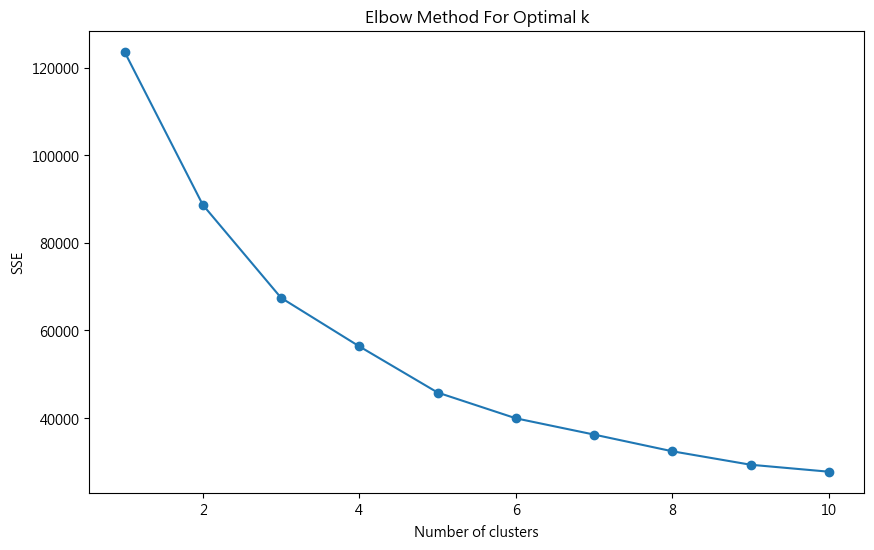

cluster
1    7779
5    6021
2    5550
0    4816
3    3765
4    2974
Name: count, dtype: int64


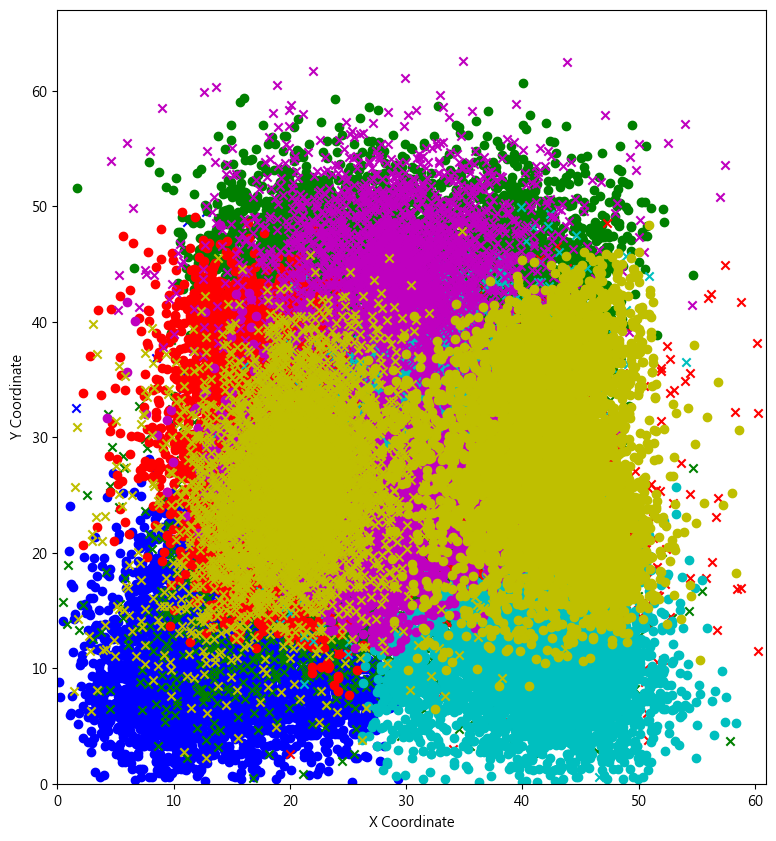

In [16]:
# #用每個shot的兩個球員位置，對shots做分群

import pandas as pd
# Load the dataset
data = pd.read_csv('convert_shot.csv',encoding='utf-8')
match = pd.read_csv('match.csv', encoding='utf-8')
set = pd.read_csv('set.csv', encoding='utf-8')
rally = pd.read_csv('rally.csv', encoding='utf-8')
match = match[["match_id", "win_A", "win_B", "lose_C", "lose_D"]]
set = set[["set_id", "match_id"]]
rally = rally[["rally_id", "set_id"]]
data = pd.merge(data, rally, on='rally_id')
data = pd.merge(data, set, on="set_id")
data = pd.merge(data, match, on="match_id")
data.to_csv('mod_processed_shot.csv', index=False)
# Filter players
players_filtered = data
# players_filtered = data[~((data['rally_id'] >= 73) & (data['rally_id'] <= 143))]

# Initialize the list to collect rows
rows_list = []
permanent_row_list = []

# Initialize previous shot variable
prev = ""
prevRallyId = players_filtered.iloc[0]['rally_id']

# Iterate over the filtered DataFrame rows
for _, row in players_filtered.iterrows():
    # put the valid shots into the big row list
    if prevRallyId != row['rally_id']:
        permanent_row_list.extend(rows_list)
        rows_list = []
        prevRallyId = row['rally_id']

    if (row['ball_type'] == '擋小球') or (row['ball_type'] == '勾球') or (row['ball_type'] == '放小球') or (row['ball_type'] == '小平球') > 0:
        row['ball_type'] = '網前小球'
    elif (row['ball_type'] == '防守回挑'):
        row['ball_type'] = '挑球'
    elif (row['ball_type'] == '防守回抽') or (row['ball_type'] == '後場抽平球') > 0:
        row['ball_type'] = '平球'
    elif (row['ball_type'] == '過度切球'):
        row['ball_type'] = '切球'
    elif (row['ball_type'] == '推球') or (row['ball_type'] == '撲球') > 0:
        row['ball_type'] = '推撲球'
    if row['shot_num'] != 1:
        prev = row["ball_type"]
    newrow = {
        "hit_player_x": None,
        "hit_player_y": None,
        "partner_x": None,
        "partner_y": None,
        "ball_type": row["ball_type"],
        "player": row["player"], 
        "shot_id": row["shot_id"],
        "rally_id": row["rally_id"],
        "set_id": row["set_id"],
        "match_id": row["match_id"]
        # "挑球": 0,
        # "殺球": 0,
        # "平球": 0,
        # "網前小球": 0,
        # "切球": 0,
        # "推撲球": 0,
        # "長球": 0
    }
    if row['player'] == row['win_A']:
        newrow["hit_player_x"] = row['player_A_x']
        newrow["hit_player_y"] = row['player_A_y']
        newrow["partner_x"] = row['player_B_x']
        newrow["partner_y"] = row['player_B_y']
    elif row['player'] == row['win_B']:
        newrow["hit_player_x"] = row['player_B_x']
        newrow["hit_player_y"] = row['player_B_y']
        newrow["partner_x"] = row['player_A_x']
        newrow["partner_y"] = row['player_A_y']
    elif row['player'] == row['lose_C']:
        newrow["hit_player_x"] = row['player_C_x']
        newrow["hit_player_y"] = row['player_C_y']
        newrow["partner_x"] = row['player_D_x']
        newrow["partner_y"] = row['player_D_y']
    elif row['player'] == row['lose_D']:
        newrow["hit_player_x"] = row['player_D_x']
        newrow["hit_player_y"] = row['player_D_y']
        newrow["partner_x"] = row['player_C_x']
        newrow["partner_y"] = row['player_C_y']
    if newrow["hit_player_y"] > 67:
        newrow["hit_player_x"] = 61 - newrow["hit_player_x"]
        newrow["hit_player_y"] = 134 - newrow["hit_player_y"]
        newrow["partner_x"] = 61 - newrow["partner_x"]
        newrow["partner_y"] = 134 - newrow["partner_y"]
        
    # Ensure only valid ball types are added
    newrow["ball_type"] = row["ball_type"]
    if newrow["hit_player_x"] < 0 or newrow['hit_player_y'] < 0 or newrow['partner_x'] < 0 or newrow['partner_y'] < 0:
        rows_list = []
    elif newrow["hit_player_x"] > 61 or newrow['hit_player_y'] > 134 or newrow['partner_x'] > 61 or newrow['partner_y'] > 134:
        rows_list = []
    else:
        rows_list.append(newrow)
# in sure the last row is in the list
permanent_row_list.extend(rows_list)

# Create a new DataFrame from the list of rows
new_df = pd.DataFrame(permanent_row_list)

# Define the desired column order
column_order = [
    "player", "shot_id", "rally_id", "set_id", "match_id", 
    "hit_player_x", "hit_player_y", "partner_x", "partner_y",
    "ball_type"
]

# Reorder the columns
new_df = new_df[column_order]
new_df = pd.get_dummies(new_df, columns=['ball_type'])
ballTypes = [
    "ball_type_切球", "ball_type_平球", "ball_type_挑球", "ball_type_推撲球", "ball_type_殺球",
    'ball_type_發短球', "ball_type_發長球", "ball_type_網前小球", "ball_type_長球"
]
new_df[ballTypes] = new_df[ballTypes].astype(int)


# Save the processed data
new_df.to_csv('processed_shot.csv', index=False, encoding='utf-8-sig')


import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
# set traditional Chinese display
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
data = pd.read_csv('processed_shot.csv')

# select features
features = data[[
    "hit_player_x", "hit_player_y", "partner_x", "partner_y"
    # , "ball_type_切球", "ball_type_平球", "ball_type_挑球", "ball_type_推撲球", "ball_type_殺球",
    # 'ball_type_發短球', "ball_type_發長球", "ball_type_網前小球", "ball_type_長球"
    ]]

# standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# use elbow method to find the optimal k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)

# plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbow_plot_balltype.png')
plt.show()

# # using silhouette analysis to determine the best k
# range_n_clusters = list(range(2, 11))
# silhouette_avg = []
# for num_clusters in range_n_clusters:
#     kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#     kmeans.fit(features_scaled)
#     cluster_labels = kmeans.labels_
#     silhouette_avg.append(silhouette_score(features_scaled, cluster_labels))
# optimal_k = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]

# print("---------------------------\n")
# print(f"The optimal number of clusters is: {optimal_k}")
# print("\n---------------------------")

# clustering
n = 6  # Best n from silhouette analysis
kmeans = KMeans(n_clusters=n, n_init=10)
data['cluster'] = kmeans.fit_predict(features)
clusterCount = data['cluster'].value_counts()
print(clusterCount)

# plot the clustering result
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

data_indices = data.index

for cluster in range(0, n):
    plt.figure(figsize=(9.15, 10.05))
    
    cluster_data = data[data['cluster'] == cluster]
    if len(cluster_data) > 100:
        sample_cluster_data = cluster_data.sample(n=100, random_state=1)
    else:
        sample_cluster_data = cluster_data
    
    plt.scatter(sample_cluster_data['hit_player_x'], sample_cluster_data['hit_player_y'], color='r', label=f'Cluster {cluster} - Hit player')
    plt.plot([sample_cluster_data['hit_player_x'], sample_cluster_data['partner_x']], [sample_cluster_data['hit_player_y'], sample_cluster_data['partner_y']], color='y', label=f'Cluster {cluster} - Partner line') 
    plt.scatter(sample_cluster_data['partner_x'], sample_cluster_data['partner_y'], color='b', label=f'Cluster {cluster} - Partner')
    plt.plot([sample_cluster_data['hit_player_x'].mean(), sample_cluster_data['partner_x'].mean()], [sample_cluster_data['hit_player_y'].mean(), 
        sample_cluster_data['partner_y'].mean()], color='g', label=f'Cluster {cluster} - Mean line', linewidth=5)
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, 61) 
    plt.ylim(0, 67) 
    plt.savefig(f'cluster_{cluster}_positions_balltypes.jpg')
    plt.close()

# plot all clustering results in one figure
plt.figure(figsize=(9.15, 10.05))
for cluster in range(n):
    cluster_data = data[data['cluster'] == cluster]
    plt.scatter(cluster_data['hit_player_x'], cluster_data['hit_player_y'], color=colors[cluster % len(colors)], label=f'Cluster {cluster} - Hit player')
    plt.scatter(cluster_data['partner_x'], cluster_data['partner_y'], color=colors[cluster % len(colors)], marker='x', label=f'Cluster {cluster} - Partner')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(0, 61) 
plt.ylim(0, 67)
# plt.legend()
plt.savefig(f'clusters_positions_balltype.jpg')
plt.show()

data.to_csv('clustered_shot.csv', index=False, encoding='utf-8')

         ball_type_切球  ball_type_平球  ball_type_挑球  ball_type_推撲球  \
cluster                                                            
0                1044           124           156              9   
1                  34           407          1057           1600   
2                  57          1178          2551            274   
3                 966           184           109              7   
4                 132           863           535             77   
5                  93          1436          2627            196   

         ball_type_殺球  ball_type_發短球  ball_type_發長球  ball_type_網前小球  \
cluster                                                               
0                2590              0              0             179   
1                 274           1742            207            2428   
2                 259              1              9            1073   
3                1747              0              0             110   
4                 417        

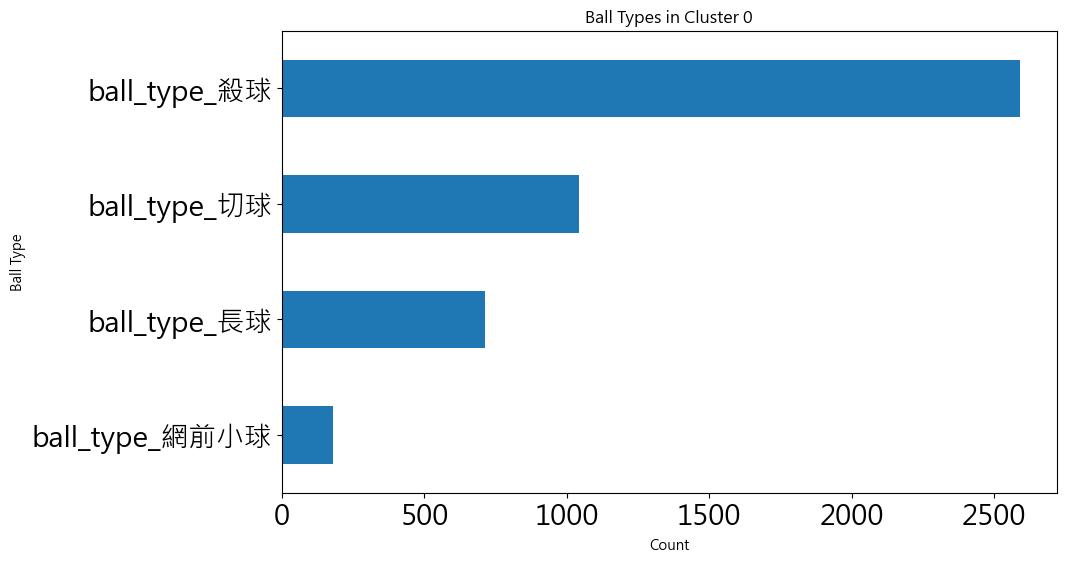

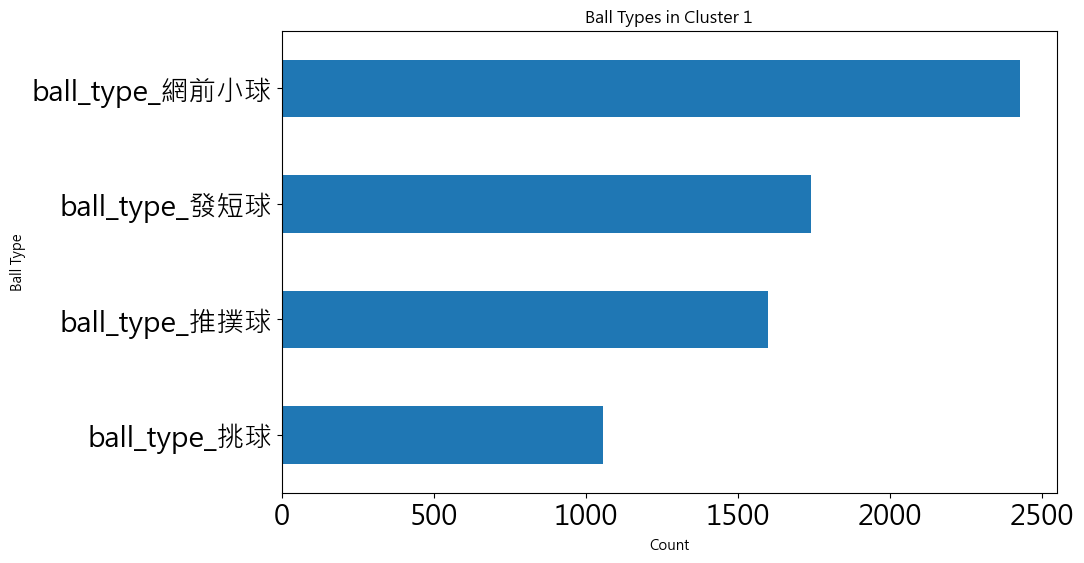

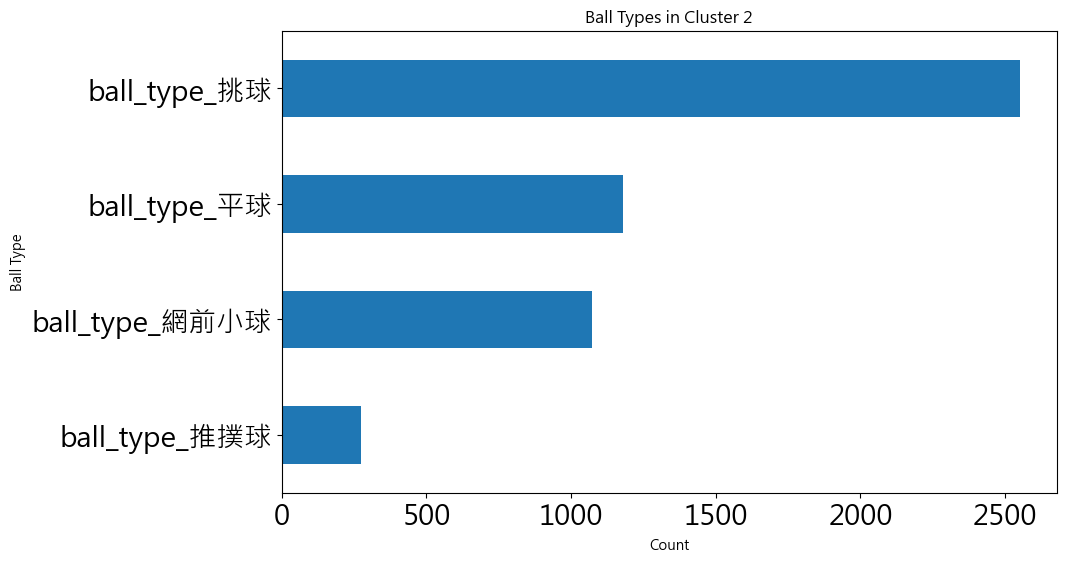

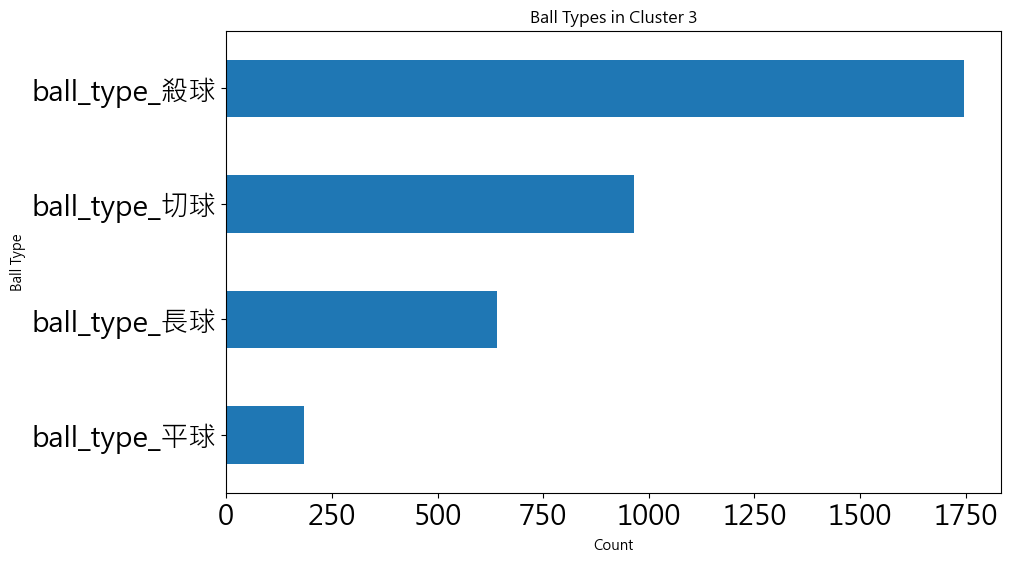

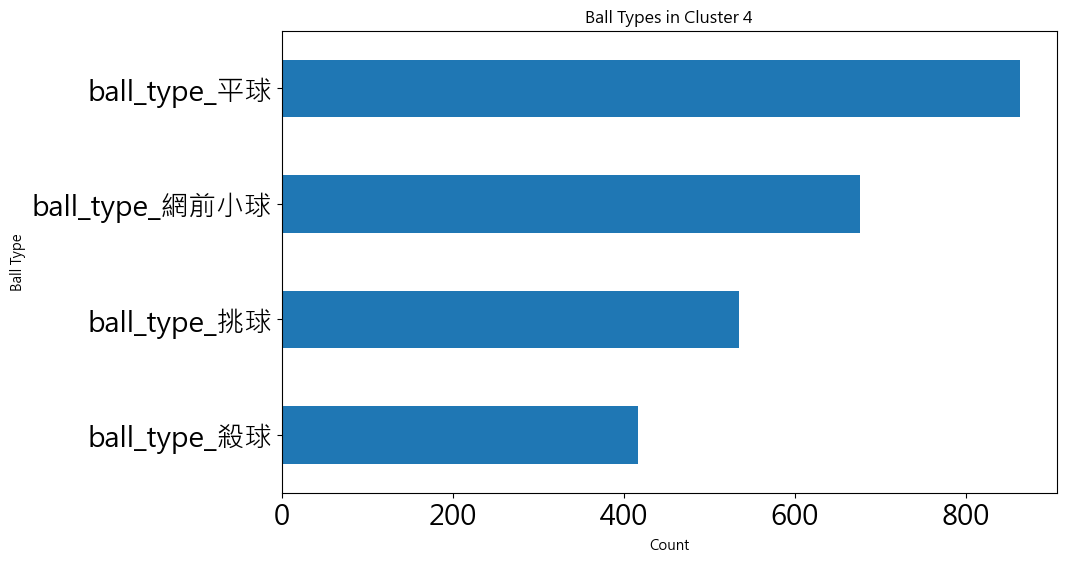

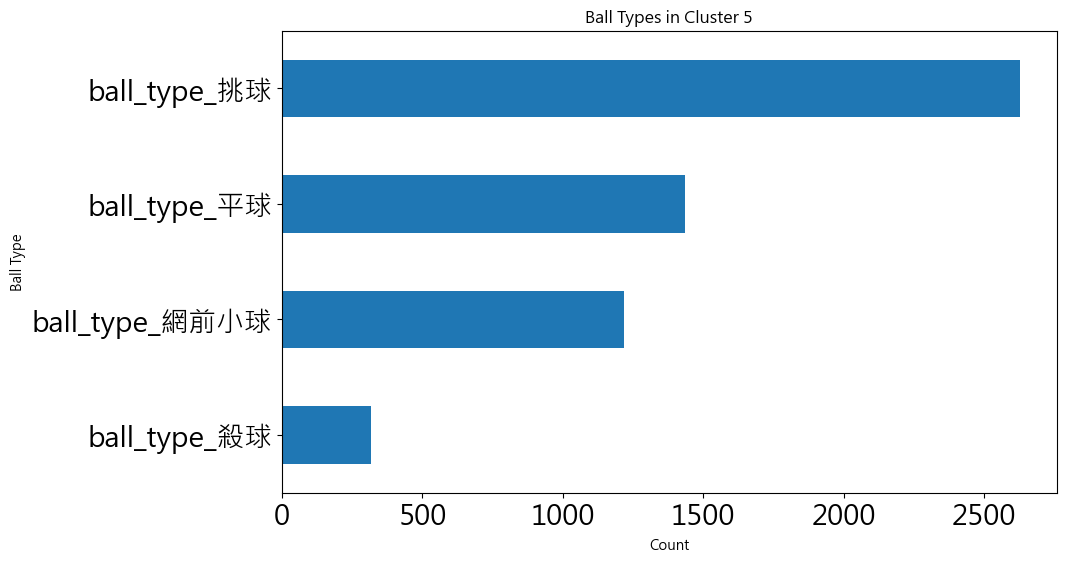

In [17]:
# count the ball type of each cluster

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'clustered_shot.csv'
df = pd.read_csv(file_path)

# Inspect the data
# print(df.head())

# Define the ball type columns
ball_type_columns = [col for col in df.columns if col.startswith('ball_type_')]

# Group by 'clusters' and sum the ball type columns
cluster_counts = df.groupby('cluster')[ball_type_columns].sum()

print(cluster_counts)
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

for cluster in cluster_counts.index:
    # Get the data for the current cluster
    cluster_data = cluster_counts.loc[cluster, ball_type_columns]
    
    # Sort the ball types in descending order and select the top four
    top_ball_types = cluster_data.sort_values(ascending=False).head(4)
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    top_ball_types.plot(kind='barh', fontsize=20)
    plt.title(f'Ball Types in Cluster {cluster}')
    plt.xlabel('Count')
    plt.ylabel('Ball Type')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
    plt.show()

In [5]:
# merge three shots into one row and add winning as last feature
cluster_num = 6

import pandas as pd

# df = pd.read_csv('clustered_shot_balltype.csv',encoding='utf-8')
data = pd.read_csv('clustered_shot.csv',encoding='utf-8')

# Define the number of previous shots to consider
num_previous_shots = 3

# Create new columns for each feature from the previous shots
for i in range(1, num_previous_shots + 1):
    data[f'ball_type_長球_prev_{i}'] = data.groupby('rally_id')['ball_type_長球'].shift(i)
    data[f'ball_type_網前小球_prev_{i}'] = data.groupby('rally_id')['ball_type_網前小球'].shift(i)
    data[f'ball_type_發長球_prev_{i}'] = data.groupby('rally_id')['ball_type_發長球'].shift(i)
    data[f'ball_type_發短球_prev_{i}'] = data.groupby('rally_id')['ball_type_發短球'].shift(i)
    data[f'ball_type_殺球_prev_{i}'] = data.groupby('rally_id')['ball_type_殺球'].shift(i)
    data[f'ball_type_推撲球_prev_{i}'] = data.groupby('rally_id')['ball_type_推撲球'].shift(i)
    data[f'ball_type_挑球_prev_{i}'] = data.groupby('rally_id')['ball_type_挑球'].shift(i)
    data[f'ball_type_平球_prev_{i}'] = data.groupby('rally_id')['ball_type_平球'].shift(i)
    data[f'ball_type_切球_prev_{i}'] = data.groupby('rally_id')['ball_type_切球'].shift(i)
    data[f'prev_{i}_cluster'] = data.groupby('rally_id')['cluster'].shift(i)

# Drop rows with NaN values resulting from the shift operation (the first few rows of each game will not have enough history)
data = data.dropna().reset_index(drop=True)

# print(data)
data.to_csv('cluster_shot_grouped_positions.csv', index=False, encoding='utf-8-sig')

# do one hot encoding on cluster
df = data
for i in range(1, 4):
    df[f'prev_{i}_cluster'] = df[f'prev_{i}_cluster'].astype(int)
    df = pd.get_dummies(df, columns=[f'prev_{i}_cluster'])
df = df.astype(int)

# add the winning column
grouped = df

grouped['next_smash'] = grouped['ball_type_殺球']
grouped['next_smash'] = grouped['next_smash'].astype(int)
count = grouped['next_smash'].value_counts()
print(count)

columns_to_drop = grouped.filter(regex=r'^shot_\d+_player$').columns
columns_to_obtain = [col for col in grouped.columns if col not in columns_to_drop]
final_df = grouped.drop(['player', 'shot_id', 'rally_id', 'set_id', 'match_id', 'hit_player_x', 
                         'hit_player_y', 'partner_x', 'partner_y', 'ball_type_切球', 'ball_type_平球',
                         'ball_type_挑球', 'ball_type_推撲球', 'ball_type_殺球', 'ball_type_發短球',
                         'ball_type_發長球', 'ball_type_網前小球', 'ball_type_長球', 'cluster'], axis=1)
print(final_df)
final_df.to_csv('cluster_final.csv', index=False, encoding='utf-8-sig')

next_smash
0    19246
1     5241
Name: count, dtype: int64
       ball_type_長球_prev_1  ball_type_網前小球_prev_1  ball_type_發長球_prev_1  \
0                        0                      0                     0   
1                        0                      0                     0   
2                        0                      0                     0   
3                        0                      0                     0   
4                        0                      0                     0   
...                    ...                    ...                   ...   
24482                    0                      0                     0   
24483                    1                      0                     0   
24484                    0                      0                     0   
24485                    0                      1                     0   
24486                    0                      0                     0   

       ball_type_發短球_prev_1  ball_type_殺

After SMOTE oversampling: 30828 samples
Class distribution after SMOTE oversampling: Counter({1: 15414, 0: 15414})
After Random undersample: 30828 samples
Class distribution after SMOTE oversampling: Counter({0: 15414, 1: 15414})

Model Accuracy: 0.8329930583911801


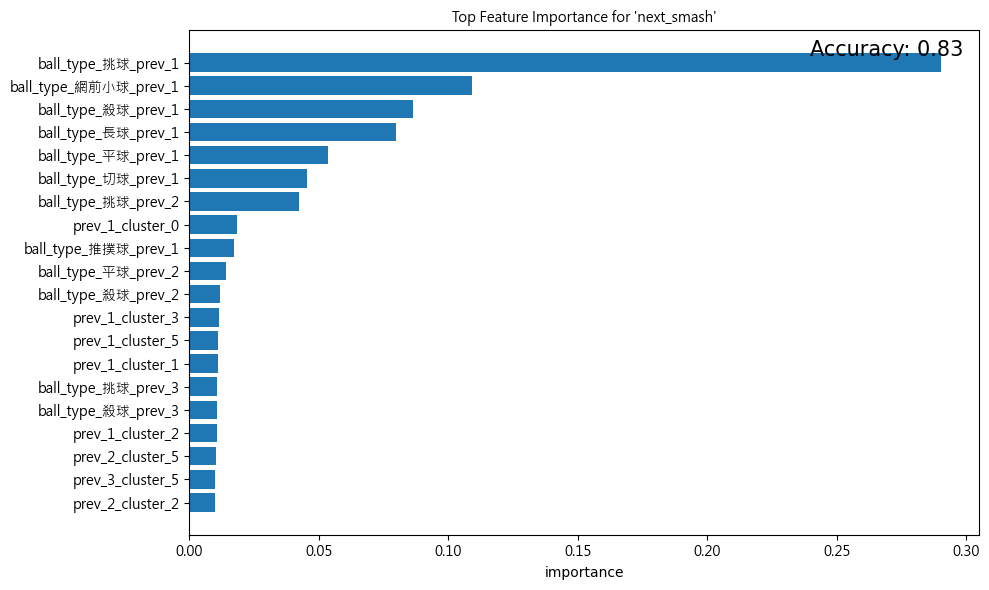


                  feature  importance
0     ball_type_挑球_prev_1    0.290459
1   ball_type_網前小球_prev_1    0.109011
2     ball_type_殺球_prev_1    0.086473
3     ball_type_長球_prev_1    0.079874
4     ball_type_平球_prev_1    0.053657
5     ball_type_切球_prev_1    0.045275
6     ball_type_挑球_prev_2    0.042439
7        prev_1_cluster_0    0.018473
8    ball_type_推撲球_prev_1    0.017221
9     ball_type_平球_prev_2    0.014105
10    ball_type_殺球_prev_2    0.011853
11       prev_1_cluster_3    0.011338
12       prev_1_cluster_5    0.011112
13       prev_1_cluster_1    0.010859
14    ball_type_挑球_prev_3    0.010827
15    ball_type_殺球_prev_3    0.010489
16       prev_1_cluster_2    0.010444
17       prev_2_cluster_5    0.010065
18       prev_3_cluster_5    0.009964
19       prev_2_cluster_2    0.009926

Least Importance:

                 feature  importance
35  ball_type_推撲球_prev_3    0.005395
36      prev_1_cluster_4    0.005236
37   ball_type_長球_prev_3    0.004632
38   ball_type_切球_prev_3    0.003

In [23]:
# select, nomorlize, and traing the model

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from collections import Counter

file_name = 'cluster_final.csv'
base_on = 'next_smash'

final_df = pd.read_csv(file_name, encoding='utf-8')

feature_columns = [col for col in final_df.columns if col not in [base_on]]
x = final_df[feature_columns]
y = final_df[base_on]

rf_model = RandomForestClassifier(n_estimators=100, random_state=26)
# rfe = RFE(estimator=rf_model, n_features_to_select=50)  # Selecting top 50 features
# x_reduced = rfe.fit_transform(x, y)
# start training
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=26)

# Apply oversampling with SMOTE
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)
print(f"After SMOTE oversampling: {X_resampled.shape[0]} samples")
print(f"Class distribution after SMOTE oversampling: {Counter(y_resampled)}")

# Apply undersampling with RandomUnderSampler
undersample = RandomUnderSampler()
X_resampled, y_resampled = undersample.fit_resample(X_resampled, y_resampled)
print(f"After Random undersample: {X_resampled.shape[0]} samples")
print(f"Class distribution after SMOTE oversampling: {Counter(y_resampled)}")

rf_model.fit(X_resampled, y_resampled)
# Make predictions and evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy}")

# Get feature importances
importances = rf_model.feature_importances_
# selected_features = x.columns[rfe.support_]
selected_features = x.columns
feature_importance = pd.DataFrame({'feature': selected_features, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

top_features = feature_importance.head(20)

font = FontProperties(fname='C:\Windows\Fonts\msjh.ttc')
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.yticks(fontproperties=font)
plt.xticks(fontproperties=font)
plt.gca().invert_yaxis()
plt.xlabel('importance')
plt.title(f'Top Feature Importance for \'{base_on}\'', fontproperties=font)
plt.text(0.98, 0.98, f'Accuracy: {accuracy:.2f}', fontsize=15, ha='right', va='top', transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

# Print top 10 most important features
# Resetting the index to add the ranking
feature_importance = feature_importance.reset_index(drop=True)
# Adding a rank column, which is the index + 1 (to start ranking from 1)
print()
print(feature_importance.head(20))
print(f"\nLeast Importance:\n")
print(feature_importance.tail(10))
print("\nclassification report: ")
print(classification_report(y_test, y_pred))

the final data frame shape:
(24487, 16)
After SMOTE oversampling: 30828 samples
Class distribution after SMOTE oversampling: Counter({1: 15414, 0: 15414})
After Random undersample: 30828 samples
Class distribution after SMOTE oversampling: Counter({0: 15414, 1: 15414})

Model Accuracy: 0.8399346672111065


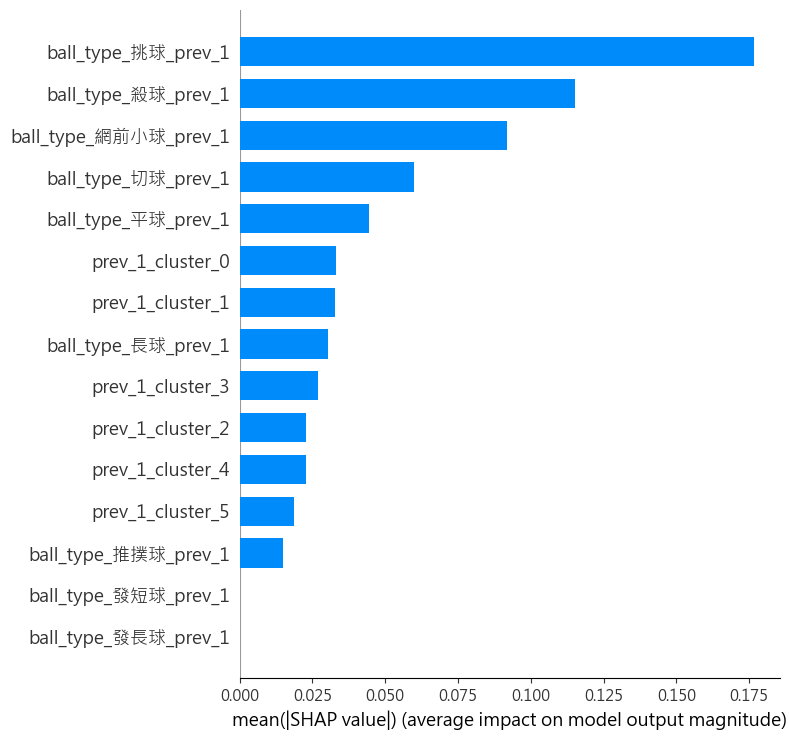

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


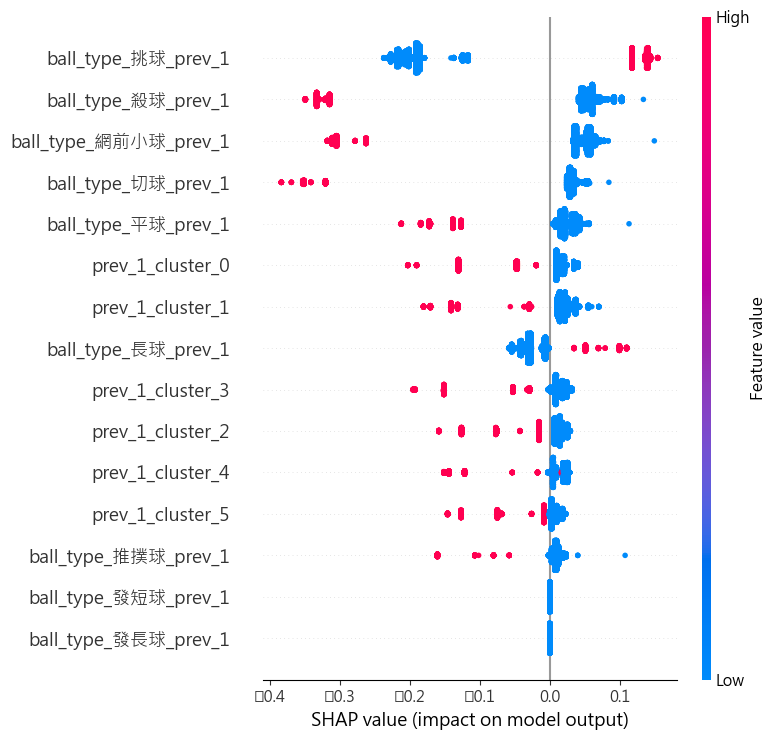

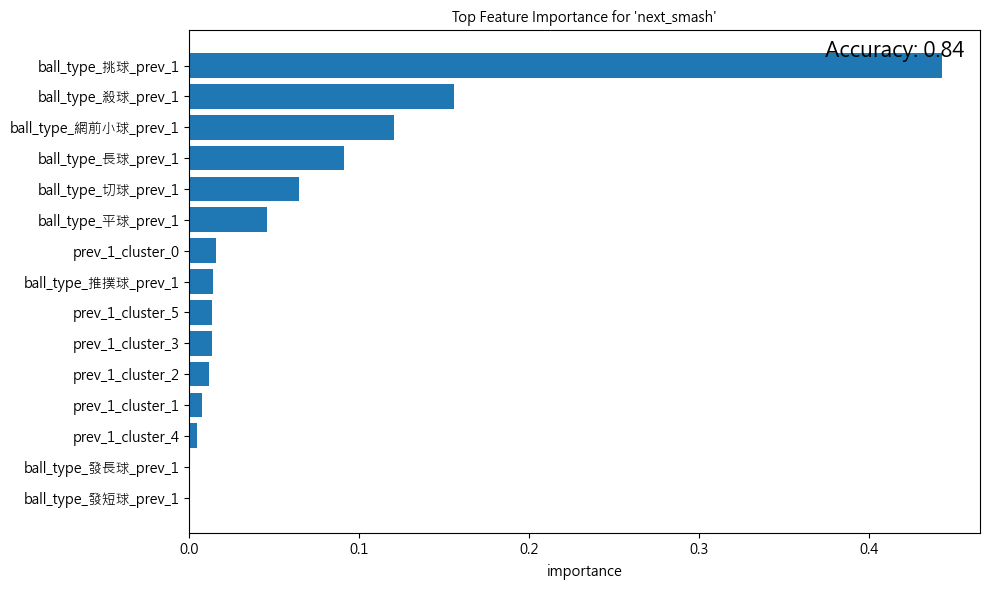


                  feature  importance
0     ball_type_挑球_prev_1    0.443215
1     ball_type_殺球_prev_1    0.155697
2   ball_type_網前小球_prev_1    0.120228
3     ball_type_長球_prev_1    0.091225
4     ball_type_切球_prev_1    0.064199
5     ball_type_平球_prev_1    0.045898
6        prev_1_cluster_0    0.015833
7    ball_type_推撲球_prev_1    0.013632
8        prev_1_cluster_5    0.013547
9        prev_1_cluster_3    0.013117
10       prev_1_cluster_2    0.011227
11       prev_1_cluster_1    0.007521
12       prev_1_cluster_4    0.004661
13   ball_type_發長球_prev_1    0.000000
14   ball_type_發短球_prev_1    0.000000

classification report: 
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      3832
           1       0.58      0.92      0.71      1066

    accuracy                           0.84      4898
   macro avg       0.78      0.87      0.80      4898
weighted avg       0.89      0.84      0.85      4898



In [34]:
# do it again, but only for the first one previous shot

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager, rcParams
from collections import Counter
import shap

file_name = 'cluster_final.csv'
base_on = 'next_smash'

final_df = pd.read_csv(file_name, encoding='utf-8')
columns_to_keep = [col for col in final_df.columns if 'prev_1' in col or 'next_smash' in col]
final_df = final_df[columns_to_keep]
print("the final data frame shape:")
print(final_df.shape)

feature_columns = [col for col in final_df.columns if col not in [base_on]]
x = final_df[feature_columns]
y = final_df[base_on]

rf_model = RandomForestClassifier(n_estimators=100, random_state=26)
# rfe = RFE(estimator=rf_model, n_features_to_select=50)  # Selecting top 50 features
# x_reduced = rfe.fit_transform(x, y)
# start training
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=26)

# Apply oversampling with SMOTE
oversample = SMOTE()
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)
print(f"After SMOTE oversampling: {X_resampled.shape[0]} samples")
print(f"Class distribution after SMOTE oversampling: {Counter(y_resampled)}")

# Apply undersampling with RandomUnderSampler
undersample = RandomUnderSampler()
X_resampled, y_resampled = undersample.fit_resample(X_resampled, y_resampled)
print(f"After Random undersample: {X_resampled.shape[0]} samples")
print(f"Class distribution after SMOTE oversampling: {Counter(y_resampled)}")

rf_model.fit(X_resampled, y_resampled)
# Make predictions and evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy}")

# Initialize SHAP explainer with the trained model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot for feature importance
# Register the font and add it to the font manager
font_path = 'C:\\Windows\\Fonts\\msjh.ttc'
font_prop = font_manager.FontProperties(fname=font_path)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = [font_prop.get_name(), 'Arial', 'DejaVu Sans']


shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=True)
shap.summary_plot(shap_values[1], X_test)

# Get feature importances
importances = rf_model.feature_importances_
# selected_features = x.columns[rfe.support_]
selected_features = x.columns
feature_importance = pd.DataFrame({'feature': selected_features, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

top_features = feature_importance.head(20)

font = FontProperties(fname='C:\Windows\Fonts\msjh.ttc')
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.yticks(fontproperties=font)
plt.xticks(fontproperties=font)
plt.gca().invert_yaxis()
plt.xlabel('importance')
plt.title(f'Top Feature Importance for \'{base_on}\'', fontproperties=font)
plt.text(0.98, 0.98, f'Accuracy: {accuracy:.2f}', fontsize=15, ha='right', va='top', transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

# Print top 10 most important features
# Resetting the index to add the ranking
feature_importance = feature_importance.reset_index(drop=True)
# Adding a rank column, which is the index + 1 (to start ranking from 1)
print()
print(feature_importance.head(20))
print("\nclassification report: ")
print(classification_report(y_test, y_pred))
